In [22]:
from __future__ import annotations
from typing import Any
import sys, os
import re
import json

from trl import SFTTrainer
import matplotlib.pyplot as plt

In [23]:
MODEL_NAME = "codellama-7b-hf-test"
MODELS_DIR_PATH = "/home/ubuntu/coq-modeling/models"

In [24]:
class TrainStep:
    def __init__(self, epoch: float, learning_rate: float, 
                 loss: float, step: int) -> None:
        assert type(epoch) == float
        assert type(learning_rate) == float
        assert type(loss) == float
        assert type(step) == int
        self.epoch = epoch
        self.learning_rate = learning_rate
        self.loss = loss
        self.step = step

    @classmethod
    def from_json(cls, json_data: Any) -> TrainStep:
        epoch = json_data["epoch"]
        learning_rate = json_data["learning_rate"]
        loss = json_data["loss"]
        step = json_data["step"]
        return cls(epoch, learning_rate, loss, step)

    @classmethod
    def steps_from_checkpoint(cls, train_state_data: Any) -> list[TrainStep]:
        steps: list[TrainStep] = []
        for step_data in train_state_data["log_history"]:
            steps.append(cls.from_json(step_data))
        return steps



In [25]:
def get_latest_train_state(models_dir, model_name):
    model_path = os.path.join(models_dir, model_name)
    max_checkpoint_num = -1 
    for checkpoint_name in os.listdir(model_path):
        checkpoint_match = re.match(r"checkpoint-(\d+)", checkpoint_name) 
        assert checkpoint_match is not None
        checkpoint_num_str, = checkpoint_match.groups()
        checkpoint_num = int(checkpoint_num_str)
        if checkpoint_num > max_checkpoint_num:
            max_checkpoint_num = checkpoint_num
    assert max_checkpoint_num > 0 
    checkpoint_name = f"checkpoint-{max_checkpoint_num}"
    train_state_loc = os.path.join(models_dir, model_name, checkpoint_name, "trainer_state.json")
    with open(train_state_loc, "r") as fin:
        return json.load(fin)


In [26]:
train_state_data = get_latest_train_state(MODELS_DIR_PATH, MODEL_NAME)
steps = TrainStep.steps_from_checkpoint(train_state_data)

In [27]:
def plot_training_loss(steps: list[TrainStep]) -> None:
    xs = [s.step for s in steps]
    ys = [s.loss for s in steps]
    fig, ax = plt.subplots()
    ax.plot(xs, ys)
    ax.set_ylabel("Training Loss")
    ax.set_xlabel("Training Steps")
    ax.set_title("Code LLama 7B Training Loss")
    

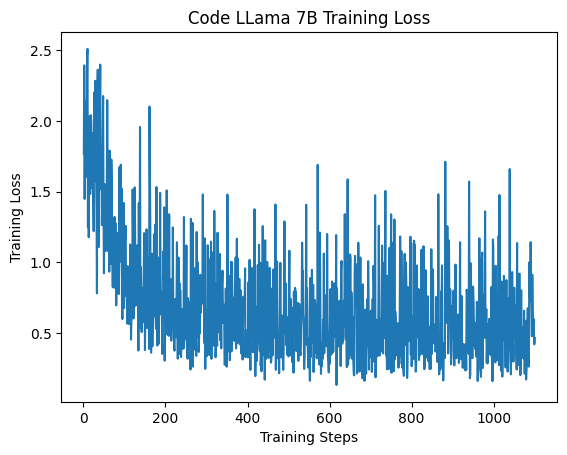

In [28]:
plot_training_loss(steps)